# 가위바위보 분류기를 만들어보자

In [1]:
import os
import glob
import random
import numpy as np
from PIL import Image
from os.path import join

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

seed_num = 2021
np.random.seed(seed_num)
random.seed(seed_num)
tf.random.set_seed(seed_num)

In [2]:
path = os.getenv("HOME") + '/aiffel/rock_scissor_paper/agit_total'

In [3]:
target_image_size = (28, 28)

In [4]:
def resize_images(img_path):
    rotation = ['/scissor', '/paper', '/rock']
    target_size = target_image_size
    num = 0
    
    for r in rotation:
        images=glob.glob(img_path + r + "/*.jpg")
        for img in images:
            old_img=Image.open(img)
            new_img=old_img.resize(target_size,Image.ANTIALIAS)
            new_img.save(img, "JPEG")
            num += 1
            
        print(f'{r[1:]} : {len(images)} images resized.')
        
    print(f'Toltal {num} images resized.')
    return num


numbumer_of_data = resize_images(path)
numbumer_of_data

scissor : 1039 images resized.
paper : 945 images resized.
rock : 1215 images resized.
Toltal 3199 images resized.


3199

In [5]:
def load_data(img_path, number_of_data=numbumer_of_data):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size = target_image_size[0]
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

#image_dir_path = path
(x_train, y_train)=load_data(path)

x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

train_scaled, val_scaled, train_target, val_target = train_test_split(
    x_train_norm, y_train, test_size = 0.2, random_state = seed_num )


print("total dataset's shape: {}".format(x_train_norm.shape))
print("train dataset's shape: {}".format(train_scaled.shape))
print("val dataset's shape: {}".format(val_scaled.shape))

학습데이터(x_train)의 이미지 개수는 3199 입니다.
total dataset's shape: (3199, 28, 28, 3)
train dataset's shape: (2559, 28, 28, 3)
val dataset's shape: (640, 28, 28, 3)


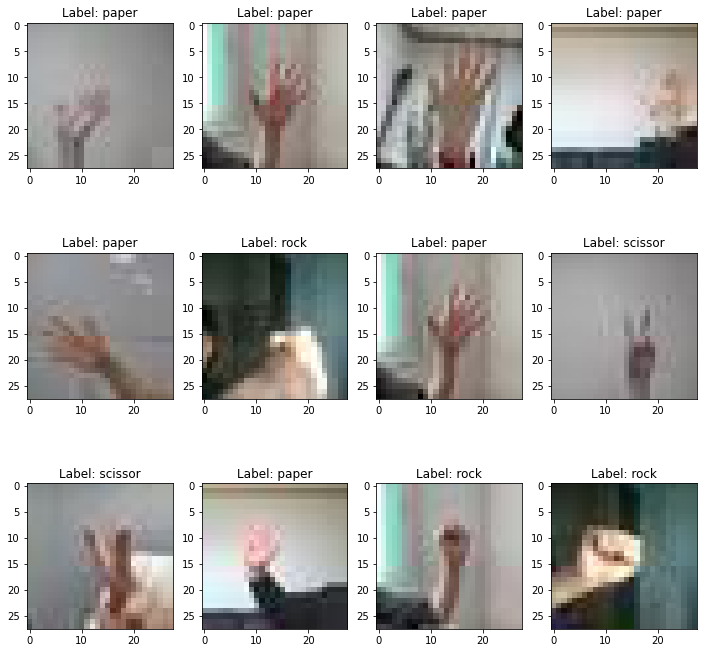

In [6]:
rsp = { 0 : "scissor", 1 : "rock", 2 : "paper"}
def preview_dataset(image, label):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    image, label = shuffle(image, label)
    for idx in range(len(image)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        plt.title(f'Label: {rsp[ label[idx] ]}')
        plt.imshow(image[idx])
        end += 1
        if end == 12:
            break
            
preview_dataset(train_scaled, train_target)

In [7]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [10]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [12]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_rotation(image)

    return image, label

In [13]:
train_scaled, train_target = augment_data(train_scaled, train_target)

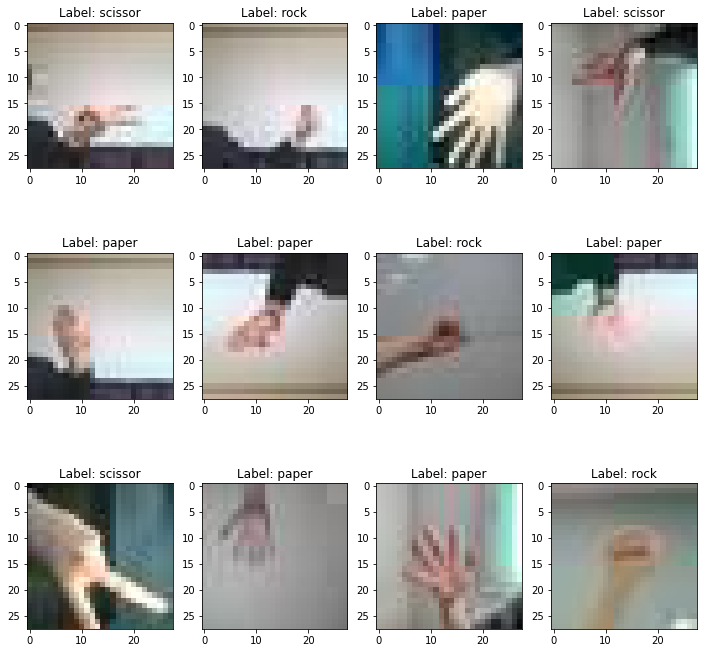

In [14]:
rsp = { 0 : "scissor", 1 : "rock", 2 : "paper"}
def preview_dataset(image, label):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    indices = tf.range(start=0, limit=tf.shape(image)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)

    image = tf.gather(image, shuffled_indices)
    label = tf.gather(label, shuffled_indices)
    for idx in range(len(image)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        plt.title(f'Label: {rsp[ label.numpy()[idx] ]}')
        plt.imshow(image[idx])
        end += 1
        if end == 12:
            break
            
preview_dataset(train_scaled, train_target)

In [15]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=32
n_channel_2=32
n_dense=16
n_train_epoch = 19

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='gelu', padding='same',input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='gelu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='gelu', kernel_initializer='he_uniform'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                25104     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 5

In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer = adam_optimizer,
             loss='sparse_categorical_crossentropy',
             metrics='accuracy')

In [17]:
batch_size = 128
number_of_train = train_scaled.shape[0]
number_of_val = val_scaled.shape[0]

steps_per_epoch = number_of_train // batch_size
validation_steps = number_of_val // batch_size

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 19
validation_steps: 5


In [18]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True,
                                                 monitor='val_accuracy' # monitor='val_loss'
                                                 )

In [19]:
history = model.fit(train_scaled, train_target,
                    validation_data = (val_scaled, val_target),
                    epochs = n_train_epoch,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks = [early_stopping_cb])

Epoch 1/19
19/19 [==============================] - 6s 262ms/step - loss: 1.0918 - accuracy: 0.3787 - val_loss: 1.0928 - val_accuracy: 0.3703
Epoch 2/19
19/19 [==============================] - 5s 254ms/step - loss: 1.0806 - accuracy: 0.4322 - val_loss: 1.0790 - val_accuracy: 0.4656
Epoch 3/19
19/19 [==============================] - 5s 248ms/step - loss: 1.0507 - accuracy: 0.4553 - val_loss: 1.0819 - val_accuracy: 0.4375
Epoch 4/19
19/19 [==============================] - 5s 250ms/step - loss: 0.9986 - accuracy: 0.4889 - val_loss: 0.9877 - val_accuracy: 0.5172
Epoch 5/19
19/19 [==============================] - 5s 251ms/step - loss: 0.9117 - accuracy: 0.5377 - val_loss: 1.0261 - val_accuracy: 0.5016
Epoch 6/19
19/19 [==============================] - 5s 249ms/step - loss: 0.8372 - accuracy: 0.5842 - val_loss: 0.9018 - val_accuracy: 0.5797
Epoch 7/19
19/19 [==============================] - 5s 257ms/step - loss: 0.7926 - accuracy: 0.6135 - val_loss: 0.8411 - val_accuracy: 0.5469
Epoch 

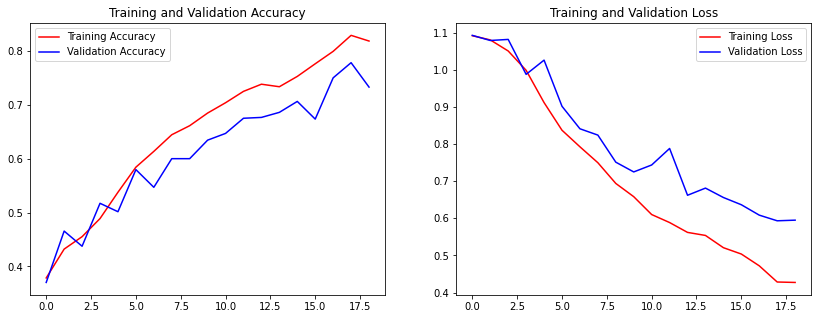

In [20]:
def eval_plot(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    acc_plot, = plt.plot(epochs, acc, 'r')
    val_acc_plot, = plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

    # Loss plot
    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    loss_plot, = plt.plot(epochs, loss, 'r')
    val_loss_plot, = plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

eval_plot(history)

In [21]:
path = os.getenv("HOME") + '/aiffel/rock_scissor_paper/seung_test'

In [22]:
rock_dir = path + '/rock'

img_name = ('seung0.jpg')
ex_file = join(rock_dir, img_name)

im = Image.open(ex_file)
im.size

(28, 28)

In [23]:
def resize_images(img_path):
    rotation = ['/scissor', '/paper', '/rock']
    target_size = target_image_size
    num = 0
    
    for r in rotation:
        images=glob.glob(img_path + r + "/*.jpg")
        for img in images[:300]:
        #for img in images:
            old_img=Image.open(img)
            new_img=old_img.resize(target_size,Image.ANTIALIAS)
            new_img.save(img, "JPEG")
            num += 1
            
        print(f'{r[1:]} : {len(images)} images resized.')
        
    print(f'Toltal {num} images resized.')
    return num

numbumer_of_data = resize_images(path)
numbumer_of_data

scissor : 100 images resized.
paper : 100 images resized.
rock : 100 images resized.
Toltal 300 images resized.


300

In [24]:
def load_data(img_path, number_of_data=numbumer_of_data):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size = target_image_size[0]
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
        if idx == 300:
            break

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
        if idx == 600:
            break
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        if idx == 900:
            break        
        
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

(x_test, y_test)=load_data(path, numbumer_of_data)

x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [25]:
train_loss, train_accuracy = model.evaluate(train_scaled, train_target)
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test)

10/10 [==============================] - 1s 16ms/step - loss: 1.0969 - accuracy: 0.6100


In [26]:
print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

train_loss: 0.4307050406932831 
train_accuracy: 0.7995310425758362
test_loss: 1.0968533754348755 
test_accuracy: 0.6100000143051147


In [27]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=3  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.8424146  0.03673553 0.12084977]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


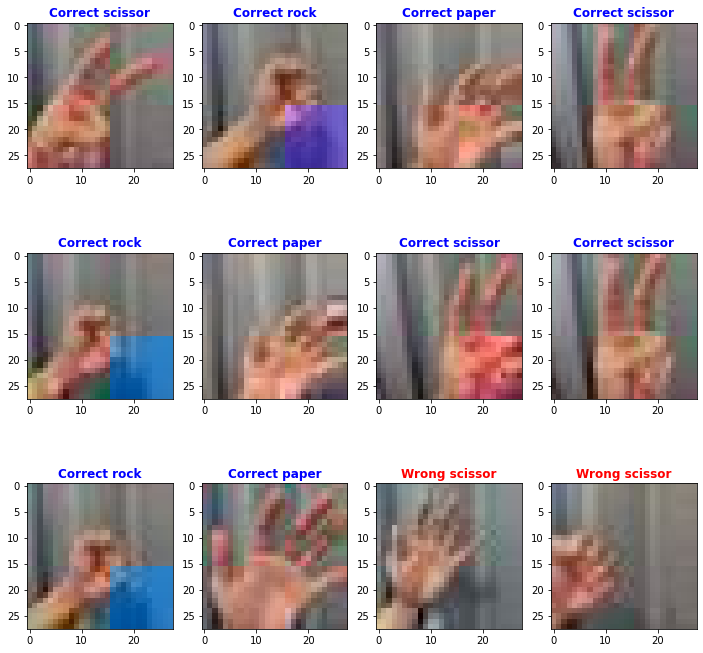

In [28]:
def postview_dataset(image, label, predicted_labels):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    image, label, predicted_labels = shuffle(image, label, predicted_labels)
    for idx in range(len(image)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        if predicted_labels[idx] == label[idx]:
            plt.title(f'Correct {rsp[predicted_labels[idx]]}', color = 'blue', fontweight ="bold")
        if predicted_labels[idx] != label[idx]:
            plt.title(f'Wrong {rsp[predicted_labels[idx]]}', color = 'red', fontweight ="bold")
        plt.imshow(image[idx])
        end += 1
        if end == 12:
            break
            
postview_dataset(x_test_norm, y_test, predicted_labels)

# 제네레이터 적용

In [38]:
path = os.getenv("HOME") + '/aiffel/rock_scissor_paper/agit_total'

In [39]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range = 40,
                shear_range = 0.2,
                horizontal_flip=True,
                vertical_flip = True,
                fill_mode = 'nearest',
                validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        path,  
        target_size=target_image_size,
        batch_size=128,
        class_mode='categorical',
        subset='training',
        shuffle=True)
 
validation_generator = train_datagen.flow_from_directory(
        path, 
        target_size=target_image_size, 
        batch_size=128,
        class_mode='categorical',
        subset='validation',
        shuffle=True)

Found 2560 images belonging to 3 classes.
Found 639 images belonging to 3 classes.


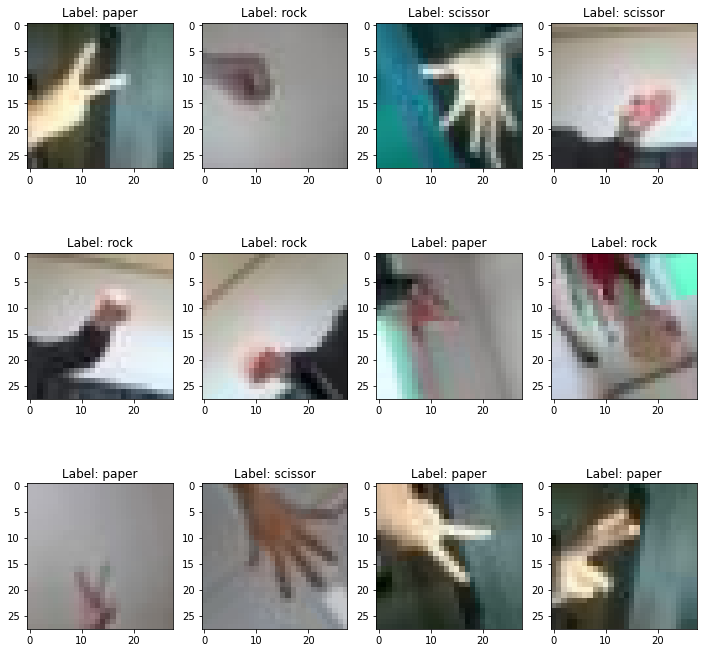

In [40]:
rsp = { 0 : "scissor", 1 : "rock", 2 : "paper"}
def preview_dataset(image_generator):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    x_train, y_train = image_generator.next()
    for idx in range(len(x_train)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        plt.title(f'Label: {rsp[np.argmax(y_train[idx])]}')
        plt.imshow(x_train[idx])
        end += 1
        if end == 12:
            break
            
preview_dataset(train_generator)

In [41]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=32
n_channel_2=64
n_dense=32
n_train_epoch = 19

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='gelu', padding='same',input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='gelu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='gelu', kernel_initializer='he_uniform'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                100384    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [42]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer = adam_optimizer,
             loss='categorical_crossentropy',
             metrics='accuracy')

In [43]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//train_generator.batch_size

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 20
validation_steps: 4


In [44]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True,
                                                 monitor='loss' # monitor='val_loss'
                                                )

In [45]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = n_train_epoch,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks = [early_stopping_cb])

Epoch 1/19
20/20 [==============================] - 9s 420ms/step - loss: 1.0927 - accuracy: 0.3930 - val_loss: 1.1053 - val_accuracy: 0.3496
Epoch 2/19
20/20 [==============================] - 8s 400ms/step - loss: 1.0530 - accuracy: 0.4102 - val_loss: 1.1193 - val_accuracy: 0.3281
Epoch 3/19
20/20 [==============================] - 8s 424ms/step - loss: 1.0032 - accuracy: 0.4723 - val_loss: 1.1115 - val_accuracy: 0.3535
Epoch 4/19
20/20 [==============================] - 8s 402ms/step - loss: 0.9419 - accuracy: 0.5105 - val_loss: 1.1229 - val_accuracy: 0.3594
Epoch 5/19
20/20 [==============================] - 8s 401ms/step - loss: 0.9187 - accuracy: 0.5117 - val_loss: 1.2111 - val_accuracy: 0.4004
Epoch 6/19
20/20 [==============================] - 8s 401ms/step - loss: 0.8930 - accuracy: 0.5090 - val_loss: 1.2325 - val_accuracy: 0.3594
Epoch 7/19
20/20 [==============================] - 8s 401ms/step - loss: 0.8914 - accuracy: 0.5316 - val_loss: 1.1133 - val_accuracy: 0.3652
Epoch 

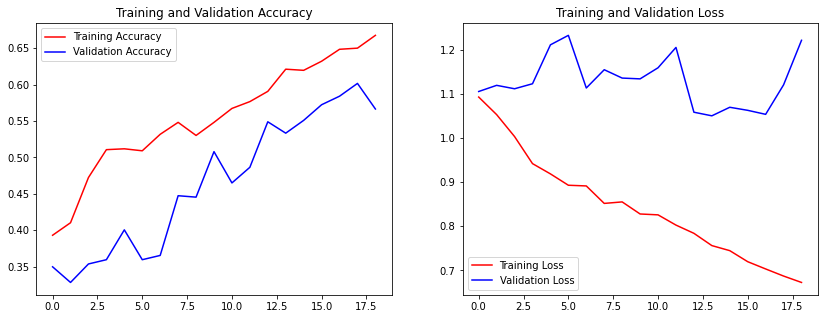

In [46]:
def eval_plot(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    acc_plot, = plt.plot(epochs, acc, 'r')
    val_acc_plot, = plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

    # Loss plot
    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    loss_plot, = plt.plot(epochs, loss, 'r')
    val_loss_plot, = plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

eval_plot(history)

In [47]:
path = os.getenv("HOME") + '/aiffel/rock_scissor_paper/seung_test'

In [48]:
numbumer_of_data = resize_images(path)
numbumer_of_data

scissor : 100 images resized.
paper : 100 images resized.
rock : 100 images resized.
Toltal 300 images resized.


300

In [49]:
(x_test, y_test)=load_data(path, numbumer_of_data)

x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_train.shape))
print("y_test shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (3199, 28, 28, 3)
y_test shape: (3199,)


In [50]:
test_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                horizontal_flip=True,
                vertical_flip = True,
                fill_mode = 'nearest')


test_generator = test_datagen.flow_from_directory(
        path,  
        target_size=(28,28),
        batch_size=128,
        class_mode='categorical',
        shuffle=True)

Found 300 images belonging to 3 classes.


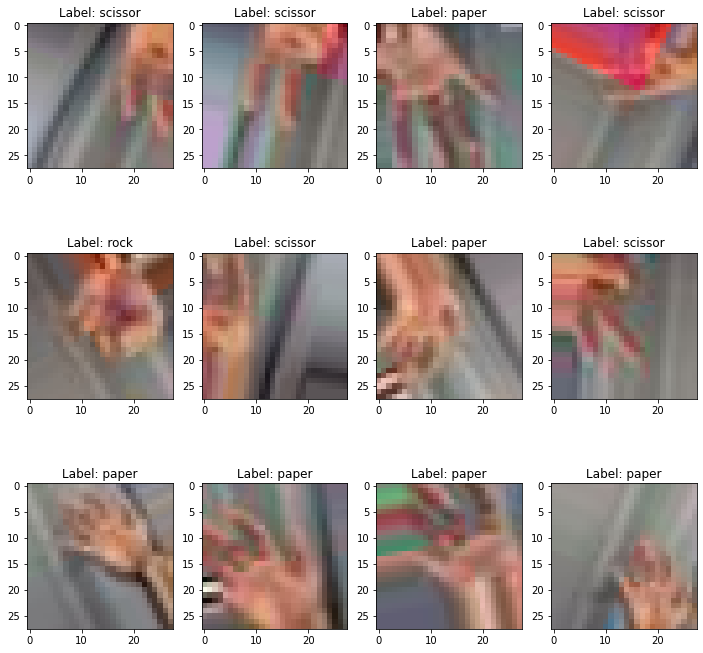

In [51]:
rsp = { 0 : "paper", 1 : "rock", 2 : "scissor"}
def preview_dataset(image_generator):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    image, label = image_generator.next()
    for idx in range(len(image)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        plt.title(f'Label: {rsp[np.argmax(label[idx])]}')
        plt.imshow(image[idx])
        end += 1
        if end == 12:
            break
            
preview_dataset(test_generator)

In [52]:
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

3/3 [==============================] - 0s 125ms/step - loss: 1.1801 - accuracy: 0.5200


In [53]:
print("train_loss: {} ".format(train_loss))
print("train_accuracy: {}".format(train_accuracy))
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

train_loss: 0.6999409794807434 
train_accuracy: 0.674609363079071
test_loss: 1.1800665855407715 
test_accuracy: 0.5199999809265137


In [54]:
predicted_result = model.predict(test_generator)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=3  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.1307916  0.05655742 0.8126509 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


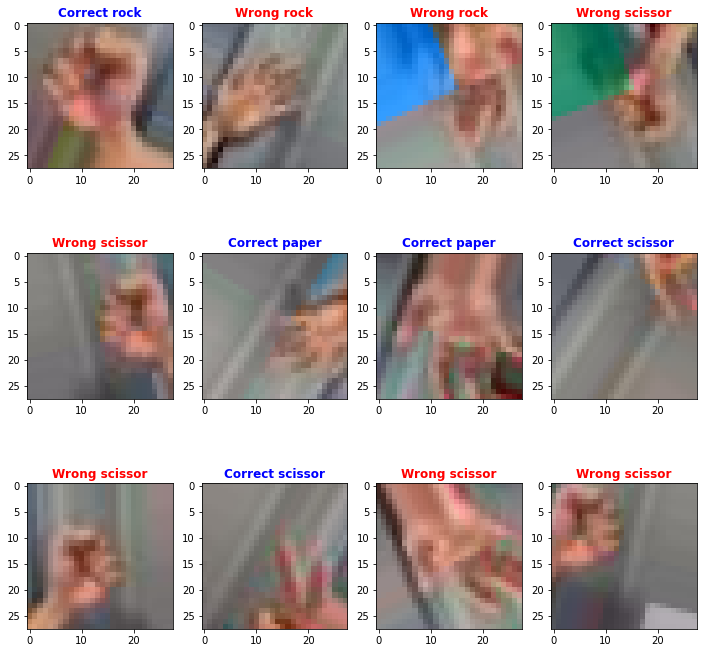

In [55]:
def postview_dataset(generator, predicted_labels):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    end = 0
    
    image, label = generator.next()
    #image, label, predicted_labels = shuffle(image, label, predicted_labels)
    
    for idx in range(len(image)):
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        if predicted_labels[idx] == np.argmax(label[idx]):
            plt.title(f'Correct {rsp[predicted_labels[idx]]}', color = 'blue', fontweight ="bold")
        if predicted_labels[idx] != np.argmax(label[idx]):
            plt.title(f'Wrong {rsp[predicted_labels[idx]]}', color = 'red', fontweight ="bold")
        plt.imshow(image[idx])
        end += 1
        if end == 12:
            break
            
postview_dataset(test_generator, predicted_labels)

# 회고

회고회고

# Reference

1. https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?select=README_rpc-cv-images.txt
2. https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=mRyHTdQhLt8C&uniqifier=1
3. https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415
4. https://github.com/digitaldaru/TensorFlow/blob/main/Rock_Paper_Scissor.ipynb
5. https://velog.io/@the_huistle/RISE-6%EC%A3%BC%EC%B0%A8-%EC%88%98%ED%96%89%EB%82%B4%EC%9A%A9
6. https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/
7. https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=FbSOb5p4Lt3q&uniqifier=1